In [1]:
import sas7bdat
from sas7bdat import *
import pandas as pd
import numpy as np
import pandas
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Flatten, Conv2D, MaxPooling1D,BatchNormalization
from keras.layers import Dropout
from keras import backend as K
#K.set_image_dim_ordering('th')
from keras.initializers import *
from keras.optimizers import *
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pre
from sklearn.utils import resample
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from imblearn.over_sampling import SMOTE
import os
from sklearn.dummy import DummyClassifier
os.environ["KMP_DUPLICATE_LIB_OK"]="True"

Using TensorFlow backend.


In [2]:
#converting sas format data into readable csv using dataframe(ovarian)
foo = SAS7BDAT('OvaryData/ovar_data_feb16_d080516.sas7bdat')
primary_data = foo.to_data_frame()

[ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192
W0712 15:17:00.839195 140672742614784 sas7bdat.py:1335] [ovar_data_feb16_d080516.sas7bdat] header length 131072 != 8192


foo = SAS7BDAT('OvaryData/screeno_data_feb16_d080516.sas7bdat')
screen_data = foo.to_data_frame()

In [3]:
ovarian_data=primary_data

In [4]:
ovarian_data = ovarian_data.reindex(sorted(ovarian_data.columns), axis=1)

In [5]:
#dcf_dthosumm column is silmilar to f_dthosumm(remember death certificate and death review,hence drop the previous)
ovarian_data=ovarian_data.drop(['age','bmi_curr','bq_compdays','breast_fh_age','dcf_dthosumm','sex',
                                'dcf_unddeath',
                                'f_unddeath','build','dcf_cancersite','rsmoker_f',
                                'is_dead','pack_years','dth_days','dth_cat','f_unddeath_ccode','f_codeath_cat',
                                'dcf_codeath_cat','smoked_f','smokea_f','ssmokea_f',
                                'dcf_unddeath_ccode','mortality_exitstat','mortality_exitage',
                                'mortality_exitdays','inci_last_contact_stat','inci_last_contact_days'
                               ,'ovar_exitstat','fstcan_exitstat','cigar',
                               'weight_f','weight20_f','weight50_f','ibup',
                               'menstrs_stat_type','curative_chemoosumm',
                                'curative_surgosumm','osumm_pathstage','confirmed_osumm','ovar_exitage',
                                'ovar_exitdays',
                                'fstcan_exitage','fstcan_exitdays','cstatusosumm_cat','breast_fh_cnt',
                                'mortality_exitdays','f_dthosumm',
                               'osumm_is_first_dx','osumm_stage'
                               ,'reasothosumm','reassymposumm','osumm_histtype','reassurvosumm','reasfollosumm',
                               'osumm_grade'],axis=1)

#column names after the merging

In [6]:
#rename the columns for readability
ovarian_data=ovarian_data.rename(columns={'f_cancersite':'death_ovarian_Cancer','hasdeo0': 'Diagnostic_Evaluation1',
'hasdeo1': 'Diagnostic_Evaluation2','hasdeo2': 'Diagnostic_Evaluation3','hasdeo3': 'Diagnostic_Evaluation4','hasdeo4': 'Diagnostic_Evaluation5',
'hasdeo5': 'Diagnostic_Evaluation6','biopolink0': 'Biopsy1','biopolink1': 'Biopsy2','biopolink2': 'Biopsy3','biopolink3': 'Biopsy4','biopolink4': 'Biopsy5',
'biopolink5': 'Biopsy6','cstatusosumm_cat': 'current_cancer_status',
'confirmed_osumm':'confirmed_ovarian_cancer',
'tvu_result0': 'transvaginal screening1','tvu_result1': 'transvaginal screening2',
'tvu_result2': 'transvaginal screening3','ca125_src0': 'ca125_test_version1',
'ca125_src1': 'ca125_test_version2','ca125_src2': 'ca125_test_version3','ca125_src3': 'ca125_test_version4',
'ca125_src4': 'ca125_test_version5','ca125_src5': 'ca125_test_version6','orem_fyro': 'ovaries_removed(yr/both)'})

In [7]:
def processCancerpriorTrial(columns):
    if(columns[0]==9):
        return -2
    elif(columns[0]==1):
        return 1
    else:
        return 0

In [8]:
ovarian_data['trial_ph_any']=ovarian_data[['trial_ph_any']].apply(processCancerpriorTrial,axis=1)

In [9]:
#columns to fill the NAN value wth -2

columns=['educat','marital','occupat','pipe','sisters','brothers','cig_stat',
        'fmenstr','menstrs','tubal','tuballig','bbd','benign_ovcyst','endometriosis','uterine_fib','mammo_history',
        'papsmear_history','pelvic_history','usound_history','bq_adminm','trypreg','livec',
        'fchilda','hystera','asppd','ibuppd','bcontra','bcontrt','hyperten_f','hearta_f','stroke_f','emphys_f',
        'bronchit_f','diabetes_f','polyps_f','arthrit_f','osteopor_f','divertic_f','gallblad_f','hispanic_f',
        'hyster_f','ovariesr_f','bcontr_f','horm_stat',
        'cigpd_f','filtered_f','cig_stop','cig_years','bmi_20','bmi_50',
        'bmi_curc','ca125_history','post_menopausal',
        'state','colon_comorbidity','liver_comorbidity','fh_cancer','breast_fh','ovarsumm_fh',
        'bq_cohort_entrydays','nrf_reason','nrf_days',
       'breast_fh','tvu_days0','tvu_days1','tvu_days2','tvu_days3','ca125_days0','ca125_days1',
         'ca125_days2','ca125_days3',
         'ca125_days4','ca125_days5','ovaries_removed(yr/both)','ca125_prot',
        'ca125_test_version1','ca125_test_version2','ca125_test_version3','ca125_test_version4','ca125_test_version5'
         ,'ca125_test_version6',
       'transvaginal screening1','transvaginal screening2','transvaginal screening3','tvu_result3','ca125_result0',
         'ca125_result1','ca125_result2','ca125_result3','ca125_result4','ca125_result5',
        'miscar','death_ovarian_Cancer','ca125_level0','ca125_level1',
                                'ca125_level2','ca125_level3','ca125_level4','ca125_level5',
        'ca125ii_level0','ca125ii_level1','ca125ii_level2','ca125ii_level3','ca125ii_level4','ca125ii_level5'
        ,'osumm_pathstage_m','osumm_pathstage_n','osumm_pathstage_t',
                               'osumm_stage_m','osumm_stage_n','osumm_stage_t','primary_trtosumm',
         'primary_trtosumm_days','ovarsumm_fh_cnt','ovarsumm_fh_age','asp','curhorm','horm_f'
        ,'prega','pregc','preg_f','stillb']

In [10]:
ovarian_data[columns]=ovarian_data[columns].fillna(value=-2.0)

In [11]:
def processFamilyBreasthistory(columns):
    if(columns[0]==0 or columns[0]==2):
        return 0
    elif(columns[0]==1 or columns[0]==9):
        return 1

In [12]:
ovarian_data['breast_fh']=ovarian_data[['breast_fh']].apply(processFamilyBreasthistory,axis=1)

In [13]:
def processRace(columns):
    if(columns[0]==7):
        return -2
    return columns[0]

In [14]:
ovarian_data['race7']=ovarian_data[['race7']].apply(processRace,axis=1)

In [15]:
def processFamilyOvarianhistory(columns):
    if(columns[0]==9):
        return 1
    return columns[0]

In [16]:
ovarian_data['ovarsumm_fh']=ovarian_data[['ovarsumm_fh']].apply(processFamilyOvarianhistory,axis=1)

In [17]:
ovarian_data=ovarian_data.rename(columns={'death_ovarian_Cancer':'output'})

In [18]:
#fill NAN with mean values
#ca125ii

columns=['bq_age','bq_cohort_entryage','height_f']
ovarian_data[columns] = ovarian_data[columns].fillna((ovarian_data[columns].mean()))

ovarian_data['thorm'] =ovarian_data['thorm'].fillna(value=0.0) 

In [19]:
pd.set_option('display.max_rows', None)
ovarian_data.isna().sum()

agelevel                        0
arm                             0
arthrit_f                       0
asp                             0
asppd                           0
bbd                             0
bcontr_f                        0
bcontra                         0
bcontrt                         0
benign_ovcyst                   0
Biopsy1                         0
Biopsy2                         0
Biopsy3                         0
Biopsy4                         0
Biopsy5                         0
Biopsy6                         0
bmi_20                          0
bmi_50                          0
bmi_curc                        0
bq_adminm                       0
bq_age                          0
bq_cohort_entryage              0
bq_cohort_entrydays             0
bq_returned                     0
breast_fh                    2612
bronchit_f                      0
brothers                        0
ca125_days0                     0
ca125_days1                     0
ca125_days2   

In [20]:
ovarian_data.fillna(-2,inplace=True)

In [21]:
ovarian_data = ovarian_data[ovarian_data.cancerosumm != 0.0]

In [22]:
ovarian_data['cancerosumm'].value_counts()

1.0    419
2.0     63
3.0     33
4.0     30
5.0      2
6.0      1
Name: cancerosumm, dtype: int64

In [23]:
def processOutput(columns):
    if(columns[0]==-2.0):
        return 0
    elif(columns[0]==4.0):
        return 1
    return columns[0]

In [24]:
ovarian_data['output']=ovarian_data[['output']].apply(processOutput,axis=1)

In [25]:
ovarian_data['output'].value_counts()

1.0     262
0.0     256
99.0      9
98.0      9
18.0      3
11.0      3
15.0      2
14.0      1
16.0      1
20.0      1
23.0      1
Name: output, dtype: int64

In [26]:
ovarian_data = ovarian_data[ovarian_data.output < 2.0]

In [27]:
ovarian_data['output'].value_counts()

1.0    262
0.0    256
Name: output, dtype: int64

columns=['ovar_days','ca125_date','ca125i_assess_days','ca125ii_assess_days',
        'examinerid','examinerid_pvis1','examinerid_pvis2','examinerid_pvis3',
        'examinerid_qvis1','examinerid_qvis2','examinerid_qvis3','physid',
        'ca125_days','ca125_level','ca125_result','ca125_result','ca125_src',
        'tvu_days','tvu_result','build']

screen_data=screen_data.drop(columns,axis=1)

columns=['tvudays_pvis1','tvudays_pvis2','tvudays_pvis3','tvures_pvis1','tvures_pvis2','tvures_pvis3',
         'tvures_qvis1','tvures_qvis2','tvures_qvis3','tvu_assess_days_q','tvu_ref',
         'ovary_diam','ovary_vol','ovcyst_diam','ovcyst_morph','ovcyst_outline','ovcyst_solid',
         'ovcyst_sum','ovcyst_vol','detl_p','detl_q','detr_p','detr_q','lantero_p','lantero_q',
         'llong_p','llong_q','ltran_p','ltran_q','lvol_p','lvol_q','rantero_p','rantero_q',
         'rlong_p','rlong_q','rtran_p','rtran_q','rvol_p','rvol_q','ovary_diaml','ovary_diamr',
         'ovary_voll','ovary_volr','ovcyst_diaml','ovcyst_diamr','ovcyst_outlinel','ovcyst_outliner',
         'ovcyst_solidl','ovcyst_solidr','ovcyst_voll','ovcyst_volr',
         
         'inad_bow','inad_dis','inad_mal',
         'inad_oth','inad_probe','inad_ref','medcomp','QAMETHOD',
         
         'inad_bow_p1','inad_bow_p2','inad_bow_p3',
         'inad_bow_q1','inad_bow_q2','inad_bow_q3',
         'inad_dis_p1','inad_dis_p2','inad_dis_p3',
         
         'inad_dis_q1','inad_dis_q2','inad_dis_q3',
         'inad_mal_p1','inad_mal_p2','inad_mal_p3',
         'inad_mal_q1','inad_mal_q2','inad_mal_q3',
         'inad_oth_p1','inad_oth_p2','inad_oth_p3',
         'inad_oth_q1','inad_oth_q2','inad_oth_q3',
         'inad_probe_p1','inad_probe_p2','inad_probe_p3',
         'inad_probe_q1','inad_probe_q2','inad_probe_q3',
         'inad_ref_q1','inad_ref_q2','inad_ref_q3',
         'inad_ref_p1','inad_ref_p2','inad_ref_p3',
         'phycons']

screen_data[columns]=screen_data[columns].fillna(value=-2.0)

screen_data['QAMETHOD'].value_counts()

screen_data['ovar_result'].value_counts()

screen_data_new = pd.DataFrame(columns=list(screen_data))

n=0
for i in range (len(ovarian_data)):
    selected_rows=screen_data.loc[screen_data['plco_id'] == ovarian_data.iloc[i]['plco_id']]
    selected_rows= selected_rows.sort_values(by=['study_yr'])
    if not selected_rows.empty:
        found=False
        for j in range (len(selected_rows)):
            if selected_rows.iloc[j]['ovar_result']==2 or selected_rows.iloc[j]['ovar_result']==3:
                found=True
                screen_data_new=screen_data_new.append(selected_rows.iloc[j],ignore_index=True)
                break
        if not found:
            screen_data_new=screen_data_new.append(selected_rows.iloc[0],ignore_index=True)
    else:
        n+=1
print(n)

screen_data_new.info()

ovarian_data_new=ovarian_data.merge(screen_data_new,how='left')

In [28]:
ovarian_data_new=ovarian_data.dropna()

In [29]:
ovarian_data_new['output'].value_counts()

1.0    262
0.0    256
Name: output, dtype: int64

In [30]:
ovarian_data_new=ovarian_data_new.drop('plco_id',axis=1)

In [31]:
dataOutput=pd.DataFrame(ovarian_data_new['output'])

# using a dummy classifier to understand the imbalance 

#Separate input features and target
y = ovarian_data.output
X = ovarian_data.drop('output', axis=1)

#setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

#DummyClassifier to predict only target 0
dummy = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

 checking unique labels
print('Unique predicted labels: ', (np.unique(dummy_pred)))

#checking accuracy
print('Test score: ', accuracy_score(y_test, dummy_pred))

trainingData_X, testingData_X, trainingData_Y, testingData_Y = train_test_split(ovarian_data_new,
                                                                                dataOutput,
                                                                                test_size = 0.2)

trainingData_X, validation_X, trainingData_Y, validation_Y = train_test_split(trainingData_X,
                                                                                trainingData_Y,
                                                                                test_size = 0.1)

trainingData_Y['output'].value_counts()

testingData_Y['output'].value_counts()

### Separate majority and minority classes
ovarian_data_majority = trainingData_X[trainingData_X.output==0.0]
ovarian_data_minority = trainingData_X[trainingData_X.output==1.0]

 
### Upsample minority class
ovarian_data_minority_upsampled = resample(ovarian_data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results

   
ovarian_data_majority_upsampled = resample(ovarian_data_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2000,    # to match majority class
                                 random_state=123) # reproducible results

#### Combine majority class with upsampled minority class
ovarian_data_upsampled = pd.concat([ovarian_data_minority_upsampled,
                                    ovarian_data_majority_upsampled,
                                    ovarian_data_majority
                                   ,ovarian_data_minority])

ovarian_data_upsampled=ovarian_data_upsampled.sample(frac=1).reset_index(drop=True)

#### Display new class counts
ovarian_data_upsampled.output.value_counts()

trainingData_X=ovarian_data_upsampled
trainingData_Y = ovarian_data_upsampled['output']

In [32]:
#trainingData_X = trainingData_X.drop(['output'],axis=1)
#testingData_X = testingData_X.drop(['output'],axis=1)
#validation_X = validation_X.drop(['output'],axis=1)
ovarian_data_new=ovarian_data_new.drop(['output'],axis=1)

In [33]:
scaler = pre.MinMaxScaler(feature_range=(0,1))
#intermediate=scaler.fit(ovarian_data_new.values)

In [34]:
def apply_smote(X_Train,Y_Train):
    
    smt=SMOTE()
    X_new=np.concatenate((X_Train,Y_Train),axis=1)

    not_dead=X_new[X_new[:,-1]==0]
    dead=X_new[X_new[:,-1]==1]

    not_dead_new=resample(not_dead,replace=True,n_samples=2000,random_state=123)
    dead_new=resample(dead,replace=True,n_samples=2000,random_state=123)

    x_train_new=np.concatenate((not_dead_new,dead),axis=0)
    y_train_new=x_train_new[:,-1]
    x_train_new=x_train_new[:,:-1]

    x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)
    y_train_new=y_train_new.reshape(y_train_new.shape[0],1)
    X_new=np.concatenate((x_train_new,y_train_new),axis=1)
    dead=X_new[X_new[:,-1]==1]

    x_train_new=np.concatenate((not_dead,dead),axis=0)
    y_train_new=x_train_new[:,-1]
    x_train_new=x_train_new[:,:-1]
    x_train_new,y_train_new=smt.fit_sample(x_train_new,y_train_new)

    x_train=x_train_new
    y_train=y_train_new
    

    x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
    

    return x_train,y_train
    

In [35]:
def get_model(x_train):

    model=Sequential()
    model.add((LocallyConnected1D(32,4,input_shape = (x_train.shape[1],x_train.shape[2]),activation='elu',
                                 kernel_initializer='he_normal')))
    model.add(MaxPooling1D(2))
    model.add((LocallyConnected1D(16, 4,activation='elu',kernel_initializer='glorot_normal',
                                  kernel_regularizer=regularizers.l2(0.01))))
    model.add(MaxPooling1D(2))
    model.add((LocallyConnected1D(4, 4,activation='relu',kernel_initializer='he_normal'
                                  ,kernel_regularizer=regularizers.l2(0.01))))
    model.add(MaxPooling1D(2))

    model.add(Flatten())


    model.add(Dense(128,activation='elu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu',kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='elu',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01)))

    model.add(Dense(16,activation='elu',kernel_initializer='lecun_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(8,activation='elu',kernel_initializer='glorot_uniform',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax',kernel_initializer='he_normal'))

    model.compile(loss='categorical_hinge', optimizer=Adam(lr=0.000015),metrics=['accuracy'])
    
    model.summary()
    
    
    return model

x_train=trainingData_X.values
x_train=intermediate.transform(x_train)

x_test=testingData_X.values
x_test=intermediate.transform(x_test)

x_valid=validation_X.values
x_valid=intermediate.transform(x_valid)

y_train=trainingData_Y.values
y_test=testingData_Y.values
#y_valid=validation_Y.values

W0712 15:17:58.079667 140672742614784 deprecation_wrapper.py:119] From /home/apurvakatti/environments/my_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 15:17:58.092902 140672742614784 deprecation_wrapper.py:119] From /home/apurvakatti/environments/my_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 15:17:58.094905 140672742614784 deprecation_wrapper.py:119] From /home/apurvakatti/environments/my_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.



Start Stratified K-Fold Training for learning rate 0.000015
This is the entire training of 1 fold Cross validation


W0712 15:17:58.577774 140672742614784 deprecation_wrapper.py:119] From /home/apurvakatti/environments/my_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0712 15:17:59.090733 140672742614784 deprecation_wrapper.py:119] From /home/apurvakatti/environments/my_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0712 15:17:59.098530 140672742614784 deprecation.py:506] From /home/apurvakatti/environments/my_env/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0712 15:17:59.112357 140672742614784 deprecati

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_1 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_2 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_3 (Local (None, 34, 4)             8840      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 17, 4)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 68)                0         
__________

4000/4000 [==============================] - 2s 566us/step - loss: 2.1418 - acc: 0.7520 - val_loss: 2.2641 - val_acc: 0.6604
Epoch 42/150
4000/4000 [==============================] - 2s 579us/step - loss: 2.1111 - acc: 0.7530 - val_loss: 2.2388 - val_acc: 0.6604
Epoch 43/150
4000/4000 [==============================] - 2s 569us/step - loss: 2.0847 - acc: 0.7537 - val_loss: 2.2121 - val_acc: 0.6604
Epoch 44/150
4000/4000 [==============================] - 2s 570us/step - loss: 2.0555 - acc: 0.7562 - val_loss: 2.1861 - val_acc: 0.6604
Epoch 45/150
4000/4000 [==============================] - 2s 565us/step - loss: 2.0280 - acc: 0.7565 - val_loss: 2.1613 - val_acc: 0.6604
Epoch 46/150
4000/4000 [==============================] - 2s 567us/step - loss: 2.0017 - acc: 0.7562 - val_loss: 2.1366 - val_acc: 0.6604
Epoch 47/150
4000/4000 [==============================] - 2s 564us/step - loss: 1.9719 - acc: 0.7590 - val_loss: 2.1126 - val_acc: 0.6604
Epoch 48/150
4000/4000 [=======================

4000/4000 [==============================] - 2s 574us/step - loss: 0.9839 - acc: 0.8482 - val_loss: 1.1823 - val_acc: 0.7170
Epoch 101/150
4000/4000 [==============================] - 2s 577us/step - loss: 0.9726 - acc: 0.8510 - val_loss: 1.1681 - val_acc: 0.7358
Epoch 102/150
4000/4000 [==============================] - 2s 570us/step - loss: 0.9612 - acc: 0.8520 - val_loss: 1.1597 - val_acc: 0.7170
Epoch 103/150
4000/4000 [==============================] - 2s 565us/step - loss: 0.9512 - acc: 0.8503 - val_loss: 1.1442 - val_acc: 0.7547
Epoch 104/150
4000/4000 [==============================] - 2s 575us/step - loss: 0.9448 - acc: 0.8488 - val_loss: 1.1448 - val_acc: 0.7170
Epoch 105/150
4000/4000 [==============================] - 2s 569us/step - loss: 0.9286 - acc: 0.8522 - val_loss: 1.1267 - val_acc: 0.7358
Epoch 106/150
4000/4000 [==============================] - 2s 568us/step - loss: 0.9221 - acc: 0.8533 - val_loss: 1.1063 - val_acc: 0.7547
Epoch 107/150
4000/4000 [================

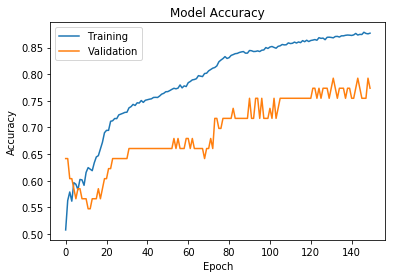

Loss Curve:


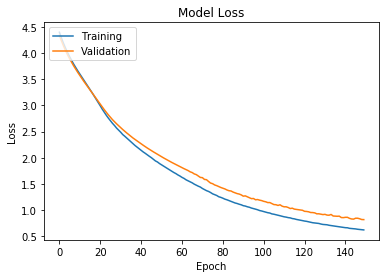

Confusion Matrix
           Pred: yes  Pred: no
True: yes         19         7
True: no           5        22
precision_score: 0.7586206896551724 specificity_score: 0.7307692307692307 recall_score: 0.8148148148148148
f1_score 0.7857142857142857
This is the entire training of 2 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_4 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_5 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_6 (Local (None, 34, 

4000/4000 [==============================] - 3s 716us/step - loss: 2.2183 - acc: 0.7672 - val_loss: 2.4751 - val_acc: 0.5849
Epoch 40/150
4000/4000 [==============================] - 3s 711us/step - loss: 2.1773 - acc: 0.7752 - val_loss: 2.4494 - val_acc: 0.5660
Epoch 41/150
4000/4000 [==============================] - 3s 702us/step - loss: 2.1512 - acc: 0.7717 - val_loss: 2.4137 - val_acc: 0.6038
Epoch 42/150
4000/4000 [==============================] - 3s 704us/step - loss: 2.1210 - acc: 0.7760 - val_loss: 2.3890 - val_acc: 0.5849
Epoch 43/150
4000/4000 [==============================] - 3s 714us/step - loss: 2.0912 - acc: 0.7732 - val_loss: 2.3638 - val_acc: 0.5849
Epoch 44/150
4000/4000 [==============================] - 3s 711us/step - loss: 2.0623 - acc: 0.7745 - val_loss: 2.3307 - val_acc: 0.6038
Epoch 45/150
4000/4000 [==============================] - 2s 619us/step - loss: 2.0335 - acc: 0.7780 - val_loss: 2.3083 - val_acc: 0.6038
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 2s 580us/step - loss: 1.0261 - acc: 0.8505 - val_loss: 1.2064 - val_acc: 0.7736
Epoch 99/150
4000/4000 [==============================] - 2s 570us/step - loss: 1.0200 - acc: 0.8473 - val_loss: 1.2026 - val_acc: 0.7547
Epoch 100/150
4000/4000 [==============================] - 2s 577us/step - loss: 1.0095 - acc: 0.8492 - val_loss: 1.1959 - val_acc: 0.7547
Epoch 101/150
4000/4000 [==============================] - 2s 579us/step - loss: 0.9964 - acc: 0.8503 - val_loss: 1.1820 - val_acc: 0.7547
Epoch 102/150
4000/4000 [==============================] - 2s 589us/step - loss: 0.9839 - acc: 0.8530 - val_loss: 1.2063 - val_acc: 0.7358
Epoch 103/150
4000/4000 [==============================] - 2s 574us/step - loss: 0.9779 - acc: 0.8522 - val_loss: 1.1554 - val_acc: 0.7547
Epoch 104/150
4000/4000 [==============================] - 2s 580us/step - loss: 0.9661 - acc: 0.8505 - val_loss: 1.2029 - val_acc: 0.7170
Epoch 105/150
4000/4000 [=================

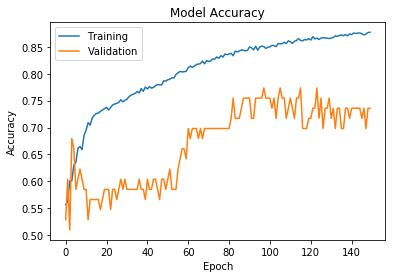

Loss Curve:


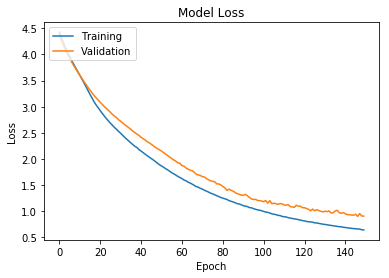

Confusion Matrix
           Pred: yes  Pred: no
True: yes         19         7
True: no           7        20
precision_score: 0.7407407407407407 specificity_score: 0.7307692307692307 recall_score: 0.7407407407407407
f1_score 0.7407407407407407
This is the entire training of 3 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_7 (Local (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_8 (Local (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_9 (Local (None, 34, 

4000/4000 [==============================] - 2s 541us/step - loss: 2.2058 - acc: 0.7845 - val_loss: 2.3336 - val_acc: 0.7115
Epoch 40/150
4000/4000 [==============================] - 2s 475us/step - loss: 2.1759 - acc: 0.7870 - val_loss: 2.3027 - val_acc: 0.7115
Epoch 41/150
4000/4000 [==============================] - 2s 460us/step - loss: 2.1420 - acc: 0.7890 - val_loss: 2.2752 - val_acc: 0.7115
Epoch 42/150
4000/4000 [==============================] - 2s 446us/step - loss: 2.1101 - acc: 0.7910 - val_loss: 2.2562 - val_acc: 0.6731
Epoch 43/150
4000/4000 [==============================] - 2s 447us/step - loss: 2.0820 - acc: 0.7935 - val_loss: 2.2218 - val_acc: 0.7115
Epoch 44/150
4000/4000 [==============================] - 2s 442us/step - loss: 2.0503 - acc: 0.7945 - val_loss: 2.2006 - val_acc: 0.6731
Epoch 45/150
4000/4000 [==============================] - 2s 442us/step - loss: 2.0245 - acc: 0.7913 - val_loss: 2.1719 - val_acc: 0.7115
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 3s 711us/step - loss: 1.0215 - acc: 0.8503 - val_loss: 1.2918 - val_acc: 0.7115
Epoch 99/150
4000/4000 [==============================] - 3s 696us/step - loss: 1.0103 - acc: 0.8538 - val_loss: 1.3226 - val_acc: 0.6731
Epoch 100/150
4000/4000 [==============================] - 3s 717us/step - loss: 0.9985 - acc: 0.8510 - val_loss: 1.2884 - val_acc: 0.7115
Epoch 101/150
4000/4000 [==============================] - 2s 623us/step - loss: 0.9860 - acc: 0.8552 - val_loss: 1.2887 - val_acc: 0.6731
Epoch 102/150
4000/4000 [==============================] - 2s 604us/step - loss: 0.9746 - acc: 0.8545 - val_loss: 1.2726 - val_acc: 0.6923
Epoch 103/150
4000/4000 [==============================] - 2s 609us/step - loss: 0.9596 - acc: 0.8575 - val_loss: 1.2768 - val_acc: 0.6731
Epoch 104/150
4000/4000 [==============================] - 2s 607us/step - loss: 0.9517 - acc: 0.8588 - val_loss: 1.2621 - val_acc: 0.6731
Epoch 105/150
4000/4000 [=================

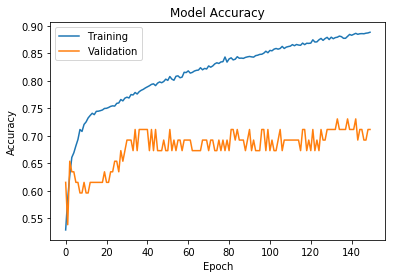

Loss Curve:


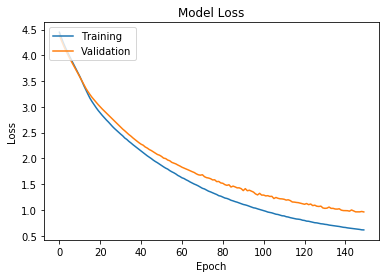

Confusion Matrix
           Pred: yes  Pred: no
True: yes         20         6
True: no           9        17
precision_score: 0.7391304347826086 specificity_score: 0.7692307692307693 recall_score: 0.6538461538461539
f1_score 0.693877551020408
This is the entire training of 4 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_10 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_11 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_12 (Loca (None, 34, 4

4000/4000 [==============================] - 3s 725us/step - loss: 2.2110 - acc: 0.7818 - val_loss: 2.1291 - val_acc: 0.7885
Epoch 40/150
4000/4000 [==============================] - 3s 706us/step - loss: 2.1736 - acc: 0.7910 - val_loss: 2.1035 - val_acc: 0.7885
Epoch 41/150
4000/4000 [==============================] - 3s 741us/step - loss: 2.1509 - acc: 0.7905 - val_loss: 2.0759 - val_acc: 0.7885
Epoch 42/150
4000/4000 [==============================] - 3s 719us/step - loss: 2.1185 - acc: 0.7920 - val_loss: 2.0503 - val_acc: 0.7885
Epoch 43/150
4000/4000 [==============================] - 3s 717us/step - loss: 2.0861 - acc: 0.7963 - val_loss: 2.0262 - val_acc: 0.7885
Epoch 44/150
4000/4000 [==============================] - 3s 738us/step - loss: 2.0580 - acc: 0.7975 - val_loss: 2.0009 - val_acc: 0.7885
Epoch 45/150
4000/4000 [==============================] - 3s 747us/step - loss: 2.0319 - acc: 0.8003 - val_loss: 1.9670 - val_acc: 0.7885
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 3s 828us/step - loss: 1.0644 - acc: 0.8490 - val_loss: 1.1063 - val_acc: 0.8077
Epoch 99/150
4000/4000 [==============================] - 3s 841us/step - loss: 1.0508 - acc: 0.8475 - val_loss: 1.0973 - val_acc: 0.8077
Epoch 100/150
4000/4000 [==============================] - 3s 858us/step - loss: 1.0457 - acc: 0.8465 - val_loss: 1.0887 - val_acc: 0.8269
Epoch 101/150
4000/4000 [==============================] - 3s 855us/step - loss: 1.0324 - acc: 0.8480 - val_loss: 1.0851 - val_acc: 0.8077
Epoch 102/150
4000/4000 [==============================] - 3s 851us/step - loss: 1.0216 - acc: 0.8485 - val_loss: 1.0727 - val_acc: 0.8077
Epoch 103/150
4000/4000 [==============================] - 3s 833us/step - loss: 1.0154 - acc: 0.8462 - val_loss: 1.0715 - val_acc: 0.8077
Epoch 104/150
4000/4000 [==============================] - 3s 860us/step - loss: 1.0022 - acc: 0.8485 - val_loss: 1.0579 - val_acc: 0.8077
Epoch 105/150
4000/4000 [=================

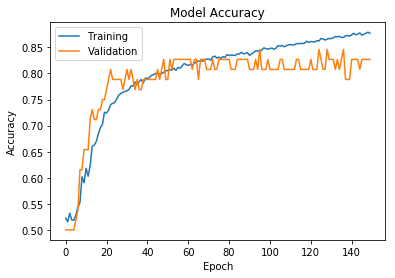

Loss Curve:


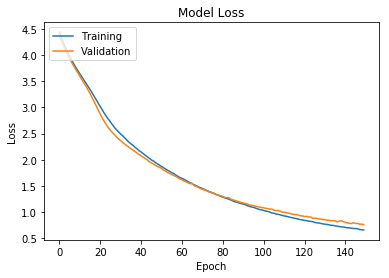

Confusion Matrix
           Pred: yes  Pred: no
True: yes         21         5
True: no           4        22
precision_score: 0.8148148148148148 specificity_score: 0.8076923076923077 recall_score: 0.8461538461538461
f1_score 0.830188679245283
This is the entire training of 5 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_13 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_14 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_15 (Loca (None, 34, 4

4000/4000 [==============================] - 4s 876us/step - loss: 2.2201 - acc: 0.7740 - val_loss: 2.4358 - val_acc: 0.6154
Epoch 40/150
4000/4000 [==============================] - 3s 833us/step - loss: 2.1783 - acc: 0.7830 - val_loss: 2.4329 - val_acc: 0.5962
Epoch 41/150
4000/4000 [==============================] - 4s 876us/step - loss: 2.1529 - acc: 0.7818 - val_loss: 2.3805 - val_acc: 0.6154
Epoch 42/150
4000/4000 [==============================] - 3s 871us/step - loss: 2.1181 - acc: 0.7860 - val_loss: 2.3203 - val_acc: 0.6346
Epoch 43/150
4000/4000 [==============================] - 3s 868us/step - loss: 2.0916 - acc: 0.7923 - val_loss: 2.3179 - val_acc: 0.6154
Epoch 44/150
4000/4000 [==============================] - 3s 780us/step - loss: 2.0587 - acc: 0.7933 - val_loss: 2.2924 - val_acc: 0.6154
Epoch 45/150
4000/4000 [==============================] - 3s 714us/step - loss: 2.0306 - acc: 0.7927 - val_loss: 2.2380 - val_acc: 0.6538
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 3s 674us/step - loss: 1.0298 - acc: 0.8578 - val_loss: 1.2551 - val_acc: 0.6923
Epoch 99/150
4000/4000 [==============================] - 3s 657us/step - loss: 1.0180 - acc: 0.8565 - val_loss: 1.2311 - val_acc: 0.7115
Epoch 100/150
4000/4000 [==============================] - 3s 721us/step - loss: 1.0062 - acc: 0.8570 - val_loss: 1.2185 - val_acc: 0.6923
Epoch 101/150
4000/4000 [==============================] - 3s 728us/step - loss: 0.9934 - acc: 0.8580 - val_loss: 1.1811 - val_acc: 0.7308
Epoch 102/150
4000/4000 [==============================] - 3s 733us/step - loss: 0.9817 - acc: 0.8585 - val_loss: 1.1780 - val_acc: 0.7308
Epoch 103/150
4000/4000 [==============================] - 3s 723us/step - loss: 0.9729 - acc: 0.8585 - val_loss: 1.1423 - val_acc: 0.7500
Epoch 104/150
4000/4000 [==============================] - 3s 722us/step - loss: 0.9694 - acc: 0.8535 - val_loss: 1.1349 - val_acc: 0.7500
Epoch 105/150
4000/4000 [=================

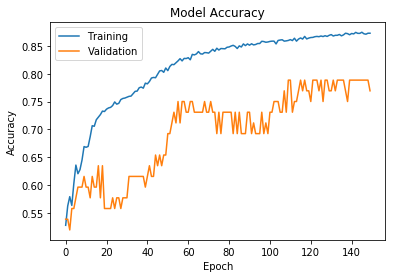

Loss Curve:


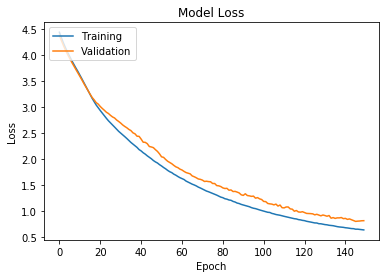

Confusion Matrix
           Pred: yes  Pred: no
True: yes         21         5
True: no           7        19
precision_score: 0.7916666666666666 specificity_score: 0.8076923076923077 recall_score: 0.7307692307692307
f1_score 0.76
This is the entire training of 6 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_16 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_17 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_18 (Loca (None, 34, 4)            

4000/4000 [==============================] - 4s 891us/step - loss: 2.1426 - acc: 0.7782 - val_loss: 2.2949 - val_acc: 0.6923
Epoch 40/150
4000/4000 [==============================] - 4s 877us/step - loss: 2.1094 - acc: 0.7865 - val_loss: 2.2676 - val_acc: 0.6731
Epoch 41/150
4000/4000 [==============================] - 4s 876us/step - loss: 2.0770 - acc: 0.7908 - val_loss: 2.2438 - val_acc: 0.6923
Epoch 42/150
4000/4000 [==============================] - 4s 880us/step - loss: 2.0416 - acc: 0.7995 - val_loss: 2.2175 - val_acc: 0.7115
Epoch 43/150
4000/4000 [==============================] - 3s 859us/step - loss: 2.0153 - acc: 0.7998 - val_loss: 2.1904 - val_acc: 0.7115
Epoch 44/150
4000/4000 [==============================] - 3s 857us/step - loss: 1.9813 - acc: 0.8040 - val_loss: 2.1734 - val_acc: 0.6731
Epoch 45/150
4000/4000 [==============================] - 3s 862us/step - loss: 1.9498 - acc: 0.8065 - val_loss: 2.1517 - val_acc: 0.7115
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 2s 590us/step - loss: 0.9946 - acc: 0.8555 - val_loss: 1.2943 - val_acc: 0.6923
Epoch 99/150
4000/4000 [==============================] - 2s 587us/step - loss: 0.9794 - acc: 0.8608 - val_loss: 1.2831 - val_acc: 0.6731
Epoch 100/150
4000/4000 [==============================] - 2s 597us/step - loss: 0.9696 - acc: 0.8588 - val_loss: 1.2753 - val_acc: 0.6731
Epoch 101/150
4000/4000 [==============================] - 2s 596us/step - loss: 0.9576 - acc: 0.8638 - val_loss: 1.2649 - val_acc: 0.6731
Epoch 102/150
4000/4000 [==============================] - 2s 593us/step - loss: 0.9461 - acc: 0.8632 - val_loss: 1.2521 - val_acc: 0.6923
Epoch 103/150
4000/4000 [==============================] - 2s 593us/step - loss: 0.9354 - acc: 0.8618 - val_loss: 1.2418 - val_acc: 0.6923
Epoch 104/150
4000/4000 [==============================] - 2s 584us/step - loss: 0.9267 - acc: 0.8642 - val_loss: 1.2322 - val_acc: 0.6731
Epoch 105/150
4000/4000 [=================

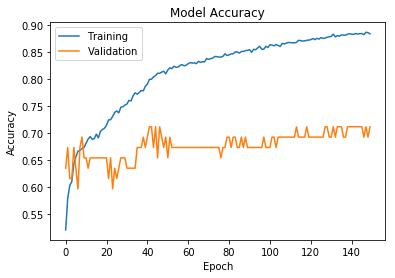

Loss Curve:


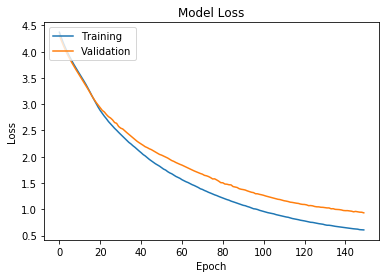

Confusion Matrix
           Pred: yes  Pred: no
True: yes         20         6
True: no           9        17
precision_score: 0.7391304347826086 specificity_score: 0.7692307692307693 recall_score: 0.6538461538461539
f1_score 0.693877551020408
This is the entire training of 7 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_19 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_20 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_21 (Loca (None, 34, 4

4000/4000 [==============================] - 2s 450us/step - loss: 2.1455 - acc: 0.7805 - val_loss: 2.3871 - val_acc: 0.6078
Epoch 40/150
4000/4000 [==============================] - 2s 459us/step - loss: 2.1191 - acc: 0.7780 - val_loss: 2.3628 - val_acc: 0.6078
Epoch 41/150
4000/4000 [==============================] - 2s 457us/step - loss: 2.0910 - acc: 0.7790 - val_loss: 2.3402 - val_acc: 0.6078
Epoch 42/150
4000/4000 [==============================] - 2s 456us/step - loss: 2.0607 - acc: 0.7830 - val_loss: 2.3185 - val_acc: 0.5882
Epoch 43/150
4000/4000 [==============================] - 2s 463us/step - loss: 2.0318 - acc: 0.7840 - val_loss: 2.3043 - val_acc: 0.6078
Epoch 44/150
4000/4000 [==============================] - 2s 477us/step - loss: 2.0020 - acc: 0.7870 - val_loss: 2.2752 - val_acc: 0.6078
Epoch 45/150
4000/4000 [==============================] - 2s 464us/step - loss: 1.9759 - acc: 0.7897 - val_loss: 2.2629 - val_acc: 0.6078
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 2s 589us/step - loss: 1.0081 - acc: 0.8642 - val_loss: 1.3538 - val_acc: 0.6667
Epoch 99/150
4000/4000 [==============================] - 2s 582us/step - loss: 0.9981 - acc: 0.8630 - val_loss: 1.3253 - val_acc: 0.6863
Epoch 100/150
4000/4000 [==============================] - 2s 585us/step - loss: 0.9897 - acc: 0.8650 - val_loss: 1.3028 - val_acc: 0.7059
Epoch 101/150
4000/4000 [==============================] - 2s 580us/step - loss: 0.9778 - acc: 0.8658 - val_loss: 1.2911 - val_acc: 0.7059
Epoch 102/150
4000/4000 [==============================] - 2s 579us/step - loss: 0.9664 - acc: 0.8670 - val_loss: 1.2895 - val_acc: 0.6863
Epoch 103/150
4000/4000 [==============================] - 2s 603us/step - loss: 0.9602 - acc: 0.8642 - val_loss: 1.2724 - val_acc: 0.6863
Epoch 104/150
4000/4000 [==============================] - 2s 540us/step - loss: 0.9471 - acc: 0.8668 - val_loss: 1.2990 - val_acc: 0.6471
Epoch 105/150
4000/4000 [=================

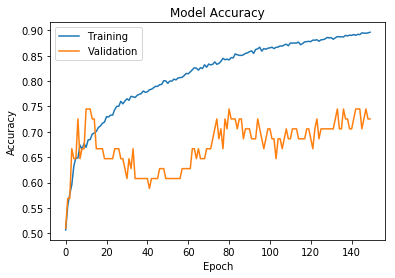

Loss Curve:


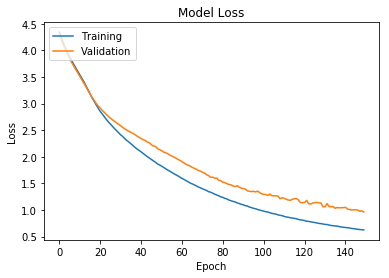

Confusion Matrix
           Pred: yes  Pred: no
True: yes         18         7
True: no           7        19
precision_score: 0.7307692307692307 specificity_score: 0.72 recall_score: 0.7307692307692307
f1_score 0.7307692307692306
This is the entire training of 8 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_22 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_23 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_24 (Loca (None, 34, 4)            

4000/4000 [==============================] - 2s 474us/step - loss: 2.1515 - acc: 0.7717 - val_loss: 2.3900 - val_acc: 0.5882
Epoch 40/150
4000/4000 [==============================] - 2s 479us/step - loss: 2.1155 - acc: 0.7752 - val_loss: 2.3587 - val_acc: 0.5882
Epoch 41/150
4000/4000 [==============================] - 2s 477us/step - loss: 2.0872 - acc: 0.7770 - val_loss: 2.3330 - val_acc: 0.5882
Epoch 42/150
4000/4000 [==============================] - 2s 482us/step - loss: 2.0616 - acc: 0.7758 - val_loss: 2.3012 - val_acc: 0.6471
Epoch 43/150
4000/4000 [==============================] - 2s 489us/step - loss: 2.0293 - acc: 0.7765 - val_loss: 2.2782 - val_acc: 0.6275
Epoch 44/150
4000/4000 [==============================] - 2s 482us/step - loss: 2.0028 - acc: 0.7752 - val_loss: 2.2592 - val_acc: 0.6078
Epoch 45/150
4000/4000 [==============================] - 2s 480us/step - loss: 1.9769 - acc: 0.7802 - val_loss: 2.2235 - val_acc: 0.6471
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 2s 474us/step - loss: 1.0452 - acc: 0.8213 - val_loss: 1.3878 - val_acc: 0.6078
Epoch 99/150
4000/4000 [==============================] - 2s 481us/step - loss: 1.0372 - acc: 0.8187 - val_loss: 1.3418 - val_acc: 0.6667
Epoch 100/150
4000/4000 [==============================] - 2s 476us/step - loss: 1.0215 - acc: 0.8215 - val_loss: 1.3604 - val_acc: 0.6078
Epoch 101/150
4000/4000 [==============================] - 2s 460us/step - loss: 1.0110 - acc: 0.8245 - val_loss: 1.3475 - val_acc: 0.6275
Epoch 102/150
4000/4000 [==============================] - 1s 371us/step - loss: 1.0033 - acc: 0.8240 - val_loss: 1.3244 - val_acc: 0.6275
Epoch 103/150
4000/4000 [==============================] - 1s 351us/step - loss: 0.9904 - acc: 0.8270 - val_loss: 1.2924 - val_acc: 0.6863
Epoch 104/150
4000/4000 [==============================] - 1s 351us/step - loss: 0.9846 - acc: 0.8250 - val_loss: 1.2896 - val_acc: 0.6667
Epoch 105/150
4000/4000 [=================

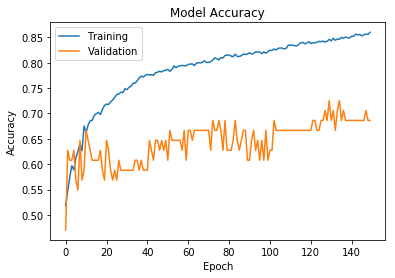

Loss Curve:


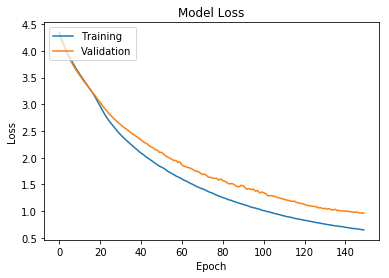

Confusion Matrix
           Pred: yes  Pred: no
True: yes         18         7
True: no           9        17
precision_score: 0.7083333333333334 specificity_score: 0.72 recall_score: 0.6538461538461539
f1_score 0.68
This is the entire training of 9 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_25 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_26 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_27 (Loca (None, 34, 4)             8840      
__

4000/4000 [==============================] - 1s 348us/step - loss: 2.2215 - acc: 0.7418 - val_loss: 2.3899 - val_acc: 0.6275
Epoch 40/150
4000/4000 [==============================] - 1s 342us/step - loss: 2.1963 - acc: 0.7408 - val_loss: 2.3596 - val_acc: 0.6275
Epoch 41/150
4000/4000 [==============================] - 1s 340us/step - loss: 2.1626 - acc: 0.7452 - val_loss: 2.3245 - val_acc: 0.5882
Epoch 42/150
4000/4000 [==============================] - 1s 348us/step - loss: 2.1378 - acc: 0.7392 - val_loss: 2.2971 - val_acc: 0.6275
Epoch 43/150
4000/4000 [==============================] - 1s 346us/step - loss: 2.1134 - acc: 0.7452 - val_loss: 2.2863 - val_acc: 0.6275
Epoch 44/150
4000/4000 [==============================] - 1s 344us/step - loss: 2.0744 - acc: 0.7475 - val_loss: 2.2526 - val_acc: 0.6275
Epoch 45/150
4000/4000 [==============================] - 1s 345us/step - loss: 2.0520 - acc: 0.7537 - val_loss: 2.2269 - val_acc: 0.6275
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 1s 344us/step - loss: 1.0476 - acc: 0.8237 - val_loss: 1.2967 - val_acc: 0.6863
Epoch 99/150
4000/4000 [==============================] - 1s 342us/step - loss: 1.0348 - acc: 0.8227 - val_loss: 1.2907 - val_acc: 0.6863
Epoch 100/150
4000/4000 [==============================] - 1s 345us/step - loss: 1.0270 - acc: 0.8245 - val_loss: 1.2895 - val_acc: 0.6667
Epoch 101/150
4000/4000 [==============================] - 1s 344us/step - loss: 1.0141 - acc: 0.8225 - val_loss: 1.2721 - val_acc: 0.6667
Epoch 102/150
4000/4000 [==============================] - 1s 347us/step - loss: 1.0011 - acc: 0.8265 - val_loss: 1.2871 - val_acc: 0.6667
Epoch 103/150
4000/4000 [==============================] - 1s 345us/step - loss: 0.9934 - acc: 0.8250 - val_loss: 1.3122 - val_acc: 0.6275
Epoch 104/150
4000/4000 [==============================] - 1s 345us/step - loss: 0.9796 - acc: 0.8273 - val_loss: 1.2343 - val_acc: 0.6863
Epoch 105/150
4000/4000 [=================

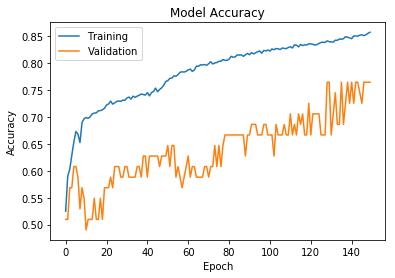

Loss Curve:


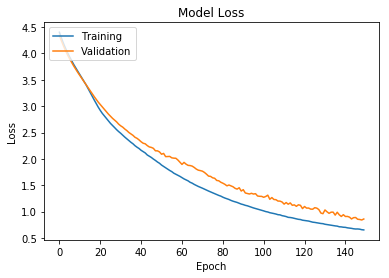

Confusion Matrix
           Pred: yes  Pred: no
True: yes         20         5
True: no           7        19
precision_score: 0.7916666666666666 specificity_score: 0.8 recall_score: 0.7307692307692307
f1_score 0.76
This is the entire training of 10 fold Cross validation
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d_28 (Loca (None, 154, 32)           24640     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
locally_connected1d_29 (Loca (None, 74, 16)            152736    
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 37, 16)            0         
_________________________________________________________________
locally_connected1d_30 (Loca (None, 34, 4)             8840      
__

4000/4000 [==============================] - 2s 467us/step - loss: 2.2470 - acc: 0.7057 - val_loss: 2.0971 - val_acc: 0.7647
Epoch 40/150
4000/4000 [==============================] - 2s 465us/step - loss: 2.2121 - acc: 0.7120 - val_loss: 2.0672 - val_acc: 0.7647
Epoch 41/150
4000/4000 [==============================] - 2s 382us/step - loss: 2.1809 - acc: 0.7157 - val_loss: 2.0288 - val_acc: 0.7647
Epoch 42/150
4000/4000 [==============================] - 1s 371us/step - loss: 2.1479 - acc: 0.7232 - val_loss: 2.0241 - val_acc: 0.7647
Epoch 43/150
4000/4000 [==============================] - 1s 372us/step - loss: 2.1211 - acc: 0.7205 - val_loss: 1.9746 - val_acc: 0.7647
Epoch 44/150
4000/4000 [==============================] - 1s 363us/step - loss: 2.0894 - acc: 0.7215 - val_loss: 1.9504 - val_acc: 0.7647
Epoch 45/150
4000/4000 [==============================] - 1s 362us/step - loss: 2.0573 - acc: 0.7268 - val_loss: 1.9084 - val_acc: 0.7843
Epoch 46/150
4000/4000 [=======================

4000/4000 [==============================] - 1s 371us/step - loss: 1.0641 - acc: 0.8063 - val_loss: 1.0333 - val_acc: 0.8039
Epoch 99/150
4000/4000 [==============================] - 1s 368us/step - loss: 1.0551 - acc: 0.8053 - val_loss: 1.0332 - val_acc: 0.8039
Epoch 100/150
4000/4000 [==============================] - 1s 369us/step - loss: 1.0419 - acc: 0.8105 - val_loss: 0.9986 - val_acc: 0.8235
Epoch 101/150
4000/4000 [==============================] - 1s 360us/step - loss: 1.0330 - acc: 0.8110 - val_loss: 1.0216 - val_acc: 0.8039
Epoch 102/150
4000/4000 [==============================] - 1s 368us/step - loss: 1.0205 - acc: 0.8103 - val_loss: 1.0120 - val_acc: 0.8039
Epoch 103/150
4000/4000 [==============================] - 1s 362us/step - loss: 1.0100 - acc: 0.8115 - val_loss: 1.0248 - val_acc: 0.7843
Epoch 104/150
4000/4000 [==============================] - 1s 370us/step - loss: 1.0008 - acc: 0.8137 - val_loss: 0.9561 - val_acc: 0.8431
Epoch 105/150
4000/4000 [=================

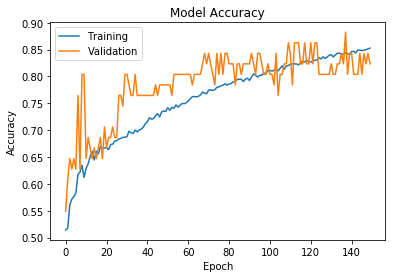

Loss Curve:


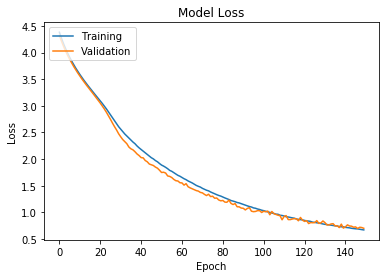

Confusion Matrix
           Pred: yes  Pred: no
True: yes         18         7
True: no           2        24
precision_score: 0.7741935483870968 specificity_score: 0.72 recall_score: 0.9230769230769231
f1_score 0.8421052631578947
The mean of all the accuracies of the models is : 0.75% (+/- 0.04%)
The validation loss and accuracies are: [[0.8194195886827865, 0.7735849135326889], [0.9078301629930172, 0.7358490599776214], [0.9617366836621211, 0.7115384615384616], [0.7647830614676843, 0.8269230815080496], [0.8112772198823782, 0.7692307692307693], [0.9315723455869235, 0.7115384661234342], [0.9601084613332561, 0.7254902007533055], [0.9625198443730673, 0.6862745121413586], [0.8602263354787639, 0.7647058846903783], [0.7020779228677937, 0.8235294059211132]]


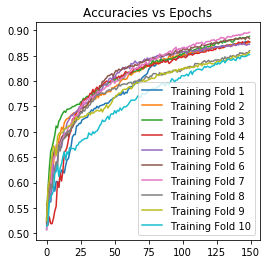

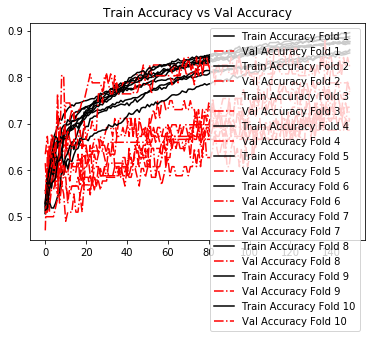

In [36]:
from sklearn.metrics import f1_score

batch_size = 32
epochs = 150
k = 10
result = []
cvscores = []
model_history = []
count = 0
#parameters_array = [0.5,0.7]


#print('Start KFold')
from sklearn.model_selection import KFold,StratifiedKFold
from keras.callbacks import EarlyStopping,ModelCheckpoint
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state = 5)


X = ovarian_data_new.values
X = X.astype('float32')
intermediate = scaler.fit(X)
X = intermediate.transform(X)


Y = dataOutput.values
Y = Y.astype('float32')


print('Start Stratified K-Fold Training for learning rate 0.000015')


#for value in parameters_array:
    #cvscores = []
    #model_history = []
    
    #print('This is the cross validation for the parameter->',value)
    
for train_index, test_index in kf.split(X,Y):
    print("This is the entire training of",(count+1),"fold Cross validation")

    #print("TRAIN:", train_index, "TEST:", test_index)

    X_Train = X[train_index]
    X_Test = X[test_index]

    Y_Train = Y[train_index]
    Y_Test = Y[test_index]

    #print("This is x_train data",X_Train)
    #print("This is y_train data",Y_Train)

    #print(X_Test)
    #print(Y_Test)


    #print("Applying Upsampling and SMOTE")
    x_train, y_train = apply_smote(X_Train,Y_Train)

    #Transforming the data
    x_test=X_Test.reshape(X_Test.shape[0],X_Test.shape[1],1)
    y_test=Y_Test


    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)

    #Traingin the model
    model = get_model(x_train)

    #es = EarlyStoppingByLossVal(monitor='loss', value=value, verbose=1)
    #mc = ModelCheckpoint('model2_best_model.h5', monitor='loss',verbose=0, save_best_only=True)


    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)

    model_history.append(history)

    scores = model.evaluate(x_test, y_test)


    cvscores.append(scores)
    print("Accuracy of the Model(Fold=",(count+1),"is: %.2f%% " % (scores[1]*100))

    print("Accuracy Curve:")
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()


    print("Loss Curve:")

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper left')
    plt.show()


    y_pred = model.predict_classes(x_test)


    y_test_new=[]
    for i in y_test:
        y_test_new.append(np.argmax(i))


    #oof = model.predict_classes(X_valid)

    # Confusion matrix

    print("Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(y_test_new, y_pred),
                   index=['True: yes', 'True: no'],
                   columns=['Pred: yes', 'Pred: no']))

    tn, fp, fn, tp = confusion_matrix(y_test_new, y_pred).ravel()
    print("precision_score:", tp/(fp + tp), "specificity_score:", tn/(tn+fp), "recall_score:", tp/(fn+tp))
    # F1 score
    print("f1_score", f1_score(y_test_new,y_pred))

    count =  count + 1

print("The mean of all the accuracies of the models is :","%.2f%% (+/- %.2f%%)" % (np.mean([x[1] for x in cvscores]), np.std([x[1] for x in cvscores])))
print('The validation loss and accuracies are:',[x for x in cvscores])



#PLOT TRAINING ACCURACIES VS EPOCHS GRAPHS
plt.figure(figsize=(4,4))
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.plot(model_history[3].history['acc'], label='Training Fold 4')
plt.plot(model_history[4].history['acc'], label='Training Fold 5')
plt.plot(model_history[5].history['acc'], label='Training Fold 6')
plt.plot(model_history[6].history['acc'], label='Training Fold 7')
plt.plot(model_history[7].history['acc'], label='Training Fold 8')
plt.plot(model_history[8].history['acc'], label='Training Fold 9')
plt.plot(model_history[9].history['acc'], label='Training Fold 10')
plt.legend()
plt.show()


plt.title('Train Accuracy vs Val Accuracy')

plt.plot(model_history[0].history['acc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_acc'], label='Val Accuracy Fold 1', color='red', linestyle = "dashdot")

plt.plot(model_history[1].history['acc'], label='Train Accuracy Fold 2', color='black', )
plt.plot(model_history[1].history['val_acc'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['acc'], label='Train Accuracy Fold 3', color='black', )
plt.plot(model_history[2].history['val_acc'], label='Val Accuracy Fold 3', color='red', linestyle = "dashdot")

plt.plot(model_history[3].history['acc'], label='Train Accuracy Fold 4', color='black', )
plt.plot(model_history[3].history['val_acc'], label='Val Accuracy Fold 4', color='red', linestyle = "dashdot")

plt.plot(model_history[4].history['acc'], label='Train Accuracy Fold 5', color='black', )
plt.plot(model_history[4].history['val_acc'], label='Val Accuracy Fold 5', color='red', linestyle = "dashdot")

plt.plot(model_history[5].history['acc'], label='Train Accuracy Fold 6', color='black', )
plt.plot(model_history[5].history['val_acc'], label='Val Accuracy Fold 6', color='red', linestyle = "dashdot")


plt.plot(model_history[6].history['acc'], label='Train Accuracy Fold 7', color='black', )
plt.plot(model_history[6].history['val_acc'], label='Val Accuracy Fold 7', color='red', linestyle = "dashdot")

plt.plot(model_history[7].history['acc'], label='Train Accuracy Fold 8', color='black', )
plt.plot(model_history[7].history['val_acc'], label='Val Accuracy Fold 8', color='red', linestyle = "dashdot")


plt.plot(model_history[8].history['acc'], label='Train Accuracy Fold 9', color='black', )
plt.plot(model_history[8].history['val_acc'], label='Val Accuracy Fold 9', color='red', linestyle = "dashdot")

plt.plot(model_history[9].history['acc'], label='Train Accuracy Fold 10', color='black', )
plt.plot(model_history[9].history['val_acc'], label='Val Accuracy Fold 10', color='red', linestyle = "dashdot")


plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(6,6))
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['acc'], label='Training Fold 1')
plt.plot(model_history[1].history['acc'], label='Training Fold 2')
plt.plot(model_history[2].history['acc'], label='Training Fold 3')
plt.plot(model_history[3].history['acc'], label='Training Fold 4')
plt.plot(model_history[4].history['acc'], label='Training Fold 5')
plt.plot(model_history[5].history['acc'], label='Training Fold 6')
plt.plot(model_history[6].history['acc'], label='Training Fold 7')
plt.plot(model_history[7].history['acc'], label='Training Fold 8')
plt.plot(model_history[8].history['acc'], label='Training Fold 9')
plt.plot(model_history[9].history['acc'], label='Training Fold 10')
plt.legend()
plt.show()

import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = pd.DataFrame(ovarian_data_upsampled.corr())

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/proco_data_feb16_d080516.sas7bdat')
diagnostic_procedure_data = foo.to_data_frame()

len(diagnostic_procedure_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/medo_data_feb16_d080516.sas7bdat')
medical_complication_data = foo.to_data_frame()

len(medical_complication_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/screeno_data_feb16_d080516.sas7bdat')
screening_data = foo.to_data_frame()

len(screening_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/scrsubo_data_feb16_d080516.sas7bdat')
screening_abnormality_data = foo.to_data_frame()

len(screening_abnormality_data)

foo = SAS7BDAT('/Users/apurvakatti/Desktop/trt_o_data_feb16_d080516.sas7bdat')
treatment_data = foo.to_data_frame()

len(treatment_data)